In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
# avoid settingwithcopy warnings
pd.options.mode.chained_assignment = None

In [42]:
if "config.yml" not in os.listdir(): 
    os.chdir("../")

In [43]:
results = Path("data/results")

In [158]:
# second run
df1 = pd.read_csv(results.joinpath("full_results_0108_1036/baseline_results.csv"))
df2 = pd.read_csv(results.joinpath("full_results_0108_1036/experiment_results.csv"))
df = pd.concat([df1, df2]).drop("Unnamed: 0", axis=1)

In [159]:
df["schedule"] = df.schedule.str.replace("custom_shuffle",  "Bin Shuffle")
df["schedule"] = df.schedule.str.replace("_",  " ")
df["schedule"] = df.schedule.str.capitalize()

df["curriculum"] = df.curriculum.str.replace("_", " ")
df["curriculum"] = df["curriculum"].str.capitalize()


In [160]:
df.loc[:, "curriculum"] = df.curriculum.fillna("None")

In [161]:
# calculate f1 score
def f1_score(prec, recall): 
    if (prec + recall) == 0: 
        return 0
    else: 
        return (2*prec*recall)/(prec+recall)

df.loc[:, "val_f1"] = df.apply(lambda x: f1_score(x["val_prec"], x["val_rec"]), axis=1)

In [162]:
summary_df = df[df.epoch == df.epochs]
summary_df = summary_df.groupby(["dataset", "curriculum", "schedule"]).agg({
    "val_acc": "min", 
    "val_prec": "min", 
    "val_rec": "min", 
    "val_f1": "min"
}).reset_index()

Let's assess the overall results

In [163]:
summary_df.sort_values(["dataset", "val_f1"])

,dataset,curriculum,schedule,val_acc,val_prec,val_rec,val_f1
6,ag_news,Reverse length,Bin shuffle,0.9116,0.9169,0.9169,0.9169
4,ag_news,None,Full,0.9124,0.9178,0.9178,0.9178
3,ag_news,Length,Bin shuffle,0.9125,0.9179,0.9179,0.9179
1,ag_news,Distance,Bin shuffle,0.9137,0.9186,0.9186,0.9186
2,ag_news,Length,Baby step,0.9141,0.9216,0.9216,0.9216
5,ag_news,Reverse length,Baby step,0.9141,0.9225,0.9225,0.9225
0,ag_news,Distance,Baby step,0.9150,0.9234,0.9234,0.9234
10,dbpedia_14,Length,Bin shuffle,0.9779,0.9813,0.9813,0.9813
9,dbpedia_14,Length,Baby step,0.9780,0.9815,0.9815,0.9815
7,dbpedia_14,Distance,Baby step,0.9779,0.9817,0.9817,0.9817


### Get the best three performing models for each dataset vs. baseline

In [171]:
summary_df["dataset_rank"] = summary_df.groupby("dataset")["val_f1"].rank(ascending=False)

In [175]:
summary_df[(summary_df.dataset_rank.isin([1,2,3, 4])) | (summary_df.curriculum == "None")]

,dataset,curriculum,schedule,val_acc,val_prec,val_rec,val_f1,dataset_rank
0,ag_news,Distance,Baby step,0.9150,0.9234,0.9234,0.9234,1.0
1,ag_news,Distance,Bin shuffle,0.9137,0.9186,0.9186,0.9186,4.0
2,ag_news,Length,Baby step,0.9141,0.9216,0.9216,0.9216,3.0
4,ag_news,None,Full,0.9124,0.9178,0.9178,0.9178,6.0
5,ag_news,Reverse length,Baby step,0.9141,0.9225,0.9225,0.9225,2.0
8,dbpedia_14,Distance,Bin shuffle,0.9794,0.9819,0.9819,0.9819,3.0
11,dbpedia_14,None,Full,0.9792,0.9820,0.9820,0.9820,2.0
13,dbpedia_14,Reverse length,Bin shuffle,0.9792,0.9822,0.9822,0.9822,1.0
14,yelp_review_full,Distance,Baby step,0.5746,0.6539,0.6539,0.6539,2.0
15,yelp_review_full,Distance,Bin shuffle,0.5734,0.6488,0.6488,0.6488,4.0


In [178]:
summary_df.loc[:, "cur_schedule"] = summary_df["curriculum"] + "-" + summary_df["schedule"]

In [179]:
summary_df.head()

,dataset,curriculum,schedule,val_acc,val_prec,val_rec,val_f1,dataset_rank,cur_schedule
0,ag_news,Distance,Baby step,0.9150,0.9234,0.9234,0.9234,1.0,Distance-Baby step
1,ag_news,Distance,Bin shuffle,0.9137,0.9186,0.9186,0.9186,4.0,Distance-Bin shuffle
2,ag_news,Length,Baby step,0.9141,0.9216,0.9216,0.9216,3.0,Length-Baby step
3,ag_news,Length,Bin shuffle,0.9125,0.9179,0.9179,0.9179,5.0,Length-Bin shuffle
4,ag_news,None,Full,0.9124,0.9178,0.9178,0.9178,6.0,None-Full


Across datasets, the best performers are: 

    - Distance-Baby
    - Distance-Bin
    - Length-Baby

In [195]:
result_df = summary_df[summary_df.cur_schedule.isin(
    ["Distance-Baby step", "Distance-Bin shuffle", "Length-Baby step", "None-Full"])
          ]


result_df = pd.pivot_table(data=result_df[["dataset", "val_f1", "cur_schedule"]], 
               values="val_f1", 
               columns="dataset", 
               index="cur_schedule")
# Reverse index for right order
result_df = result_df.reindex(index=result_df.index[::-1])
result_df *= 100
result_df = result_df.round(decimals=2)

In [197]:
result_df

dataset,ag_news,dbpedia_14,yelp_review_full
cur_schedule,,,
None-Full,91.78,98.20,64.70
Length-Baby step,92.16,98.15,65.42
Distance-Bin shuffle,91.86,98.19,64.88
Distance-Baby step,92.34,98.17,65.39


Looks like the baby step - distance combination is performing best. We zoom in on this and train across seeds. 

In [127]:
summary_df[(summary_df.curriculum.isin(["None", "distance"])) & (summary_df.schedule.isin(["full", "baby_step"]))]

,dataset,curriculum,schedule,val_acc,val_prec,val_rec,val_f1
0,ag_news,None,full,0.9124,0.9178,0.9178,0.9178
1,ag_news,distance,baby_step,0.9150,0.9234,0.9234,0.9234
7,dbpedia_14,None,full,0.9792,0.9820,0.9820,0.9820
8,dbpedia_14,distance,baby_step,0.9779,0.9817,0.9817,0.9817
14,yelp_review_full,None,full,0.5738,0.6470,0.6470,0.6470
15,yelp_review_full,distance,baby_step,0.5746,0.6539,0.6539,0.6539


#### Deep dive into units per seed

In [198]:
seed_df = pd.read_csv(results.joinpath("full_results_0107_2148/seed_experiments.csv")).drop("Unnamed: 0", axis=1)
seed_df["curriculum"] = seed_df["curriculum"].fillna("None")

In [199]:
# select final result
seed_df = seed_df[seed_df.epoch == seed_df.epochs]
# seed_df.groupby(["dataset", "schedule", "curriculum"])

In [200]:
# calculate f1 score
seed_df.loc[:, "val_f1"] = seed_df.apply(lambda x: f1_score(x["val_prec"], x["val_rec"]), axis=1)
seed_df.loc[:, "f1_std"] = seed_df["val_f1"]
seed_df.loc[:, "model"] = seed_df.curriculum.map({"None": "FastText", "distance": "CurriculumText"})

In [246]:
temp_df = seed_df[["dataset", "seed", "val_f1", "model"]]
temp_df

temp_df = pd.pivot_table(data=temp_df, 
               values="val_f1", 
               index="seed", 
               columns=["dataset", "model"])

temp_df.loc["Avg.", :] = temp_df.mean(axis=0)
temp_df.loc["std", :] = temp_df.std(axis=0)
temp_df *= 100
temp_df = temp_df.round(2)
print(temp_df.shape)
temp_df

(7, 6)


dataset        ag_news              dbpedia_14          yelp_review_full  \
model   CurriculumText FastText CurriculumText FastText   CurriculumText   
seed                                                                       
1                92.43    91.78          98.09    98.20            65.86   
2                92.24    91.96          98.13    98.17            65.60   
3                92.40    91.77          98.09    98.24            65.63   
4                92.44    91.98          98.07    98.20            65.61   
5                92.45    92.13          98.12    98.21            65.63   
Avg.             92.39    91.92          98.10    98.20            65.67   
std               0.08     0.14           0.02     0.02             0.10   

dataset           
model   FastText  
seed              
1          64.70  
2          65.36  
3          64.92  
4          64.75  
5          65.20  
Avg.       64.99  
std         0.26

#### Train time per epoch

In [328]:
time_df = df[df.epoch == df.epochs]

We can see that the baby step algorithm is not the quickest on the already well-performing tasks. The reason for this is that the FastText algorithm already converges very quickly on those task and the "baby step" algorithm is actually slowing down the convergence (i.e. the task is so simple, that no curriculum is needed).

In [329]:
time_df.loc[:, "cur_schedule"] = time_df["curriculum"] + "-" + time_df["schedule"]

In [317]:
time_df.head()

,epoch,train_acc,val_acc,data_share,val_prec,val_rec,train_time,epochs,dataset,seed,schedule,curriculum,val_f1,cur_schedule
14,14.0,0.9549,0.9124,1.0,0.9178,0.9178,13.570643,14.0,ag_news,1,Full,None,0.9178,None-Full
29,14.0,0.9889,0.9792,1.0,0.9820,0.9820,73.324424,14.0,dbpedia_14,1,Full,None,0.9820,None-Full
44,14.0,0.6077,0.5738,1.0,0.6470,0.6470,80.752743,14.0,yelp_review_full,1,Full,None,0.6470,None-Full
14,14.0,0.9434,0.9150,1.0,0.9234,0.9234,15.223314,14.0,ag_news,1,Baby step,Distance,0.9234,Distance-Baby step
29,14.0,0.9490,0.9137,1.0,0.9186,0.9186,20.651268,14.0,ag_news,1,Bin shuffle,Distance,0.9186,Distance-Bin shuffle


In [318]:
time_df = time_df.sort_values(by=["dataset", "train_time"])
time_df = pd.pivot(data=time_df[["train_time", "dataset", "cur_schedule"]], 
         values="train_time", 
         index="cur_schedule", 
         columns="dataset")
time_df = time_df.round(0).astype("int").astype("str") + "s"

In [319]:
time_df = time_df.sort_values(by="ag_news")

In [320]:
time_df

dataset,ag_news,dbpedia_14,yelp_review_full
cur_schedule,,,
None-Full,14s,73s,81s
Distance-Baby step,15s,75s,70s
Length-Baby step,16s,82s,70s
Reverse length-Baby step,16s,76s,72s
Distance-Bin shuffle,21s,111s,98s
Length-Bin shuffle,21s,114s,117s
Reverse length-Bin shuffle,21s,113s,116s


#### Plot the speed of convergence on two datasets

In [462]:
# dataset = "ag_news"
dataset = "yelp_review_full"
plot_df = df.copy()
plot_df.loc[:, "cur_schedule"] = plot_df["curriculum"] + "-" + plot_df["schedule"]
plot_df = plot_df[(plot_df.dataset==dataset) & (plot_df.cur_schedule.isin(["None-Full", "Distance-Baby step"]))]
plot_df["epoch"] += 1
plot_df["epoch"] = plot_df["epoch"].astype("int")
plot_df["model"] = plot_df.schedule.map({"Full": "FastText", "Baby step": "CurriculumText"})


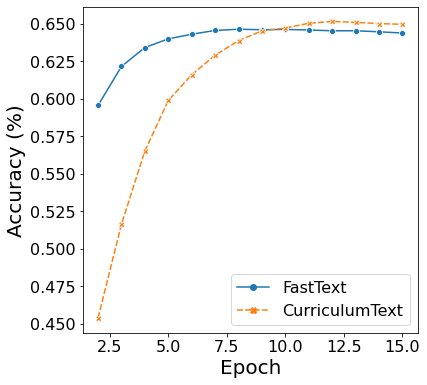

<Figure size 432x288 with 0 Axes>

In [465]:
plot_df = plot_df[["epoch", "val_acc", "model"]]
plot_df = plot_df.rename({"epoch": "Epoch", "val_acc": "Accuracy", "model": "Model"}, axis=1)

plot_df = plot_df.reset_index().drop("index", axis=1)

fig, ax = plt.subplots(figsize=(6, 6))

sns.lineplot(ax=ax, data=plot_df[plot_df.Epoch>1], x="Epoch", y="Accuracy", hue="Model", markers=True, style="Model")

dataset_title = " ".join(dataset.split("_")).capitalize()

#     ax.set_title(f'{dataset_title}', fontweight="bold", size=20)  # Title
ax.set_ylabel('Accuracy (%)', fontsize=20.0)  # Y label
ax.set_xlabel('Epoch', fontsize=20)  # X label
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.legend(prop={'size': 16})
plt.show()
plt.savefig(f"data/results/{dataset}_val_acc")

In [430]:
def plot_val_acc_comparison(dataset): 
    plot_df = df.copy()
    plot_df.loc[:, "cur_schedule"] = plot_df["curriculum"] + "-" + plot_df["schedule"]
    plot_df = plot_df[(plot_df.dataset==dataset) & (plot_df.cur_schedule.isin(["None-Full", "Distance-Baby step"]))]
    plot_df["epoch"] += 1
    plot_df["epoch"] = plot_df["epoch"].astype("int")
    plot_df["model"] = plot_df.schedule.map({"Full": "FastText", "Baby step": "CurriculumText"})
    plot_df = plot_df[["epoch", "val_acc", "model"]]
    plot_df = plot_df.rename({"epoch": "Epoch", "val_acc": "Accuracy", "model": "Model"}, axis=1)

    plot_df = plot_df.reset_index().drop("index", axis=1)
    
    fig, ax = plt.subplots(figsize=(6, 6))

    sns.lineplot(ax=ax, data=plot_df[plot_df.Epoch>1], x="Epoch", y="Accuracy", hue="Model", markers=True, style="Model")

    dataset_title = " ".join(dataset.split("_")).capitalize()
    
#     ax.set_title(f'{dataset_title}', fontweight="bold", size=20)  # Title
    ax.set_ylabel('Accuracy (%)', fontsize=20.0)  # Y label
    ax.set_xlabel('Epoch', fontsize=20)  # X label
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.legend(prop={'size': 16})
    plt.show()
    plt.savefig(f"data/results/{dataset}_val_acc")
    

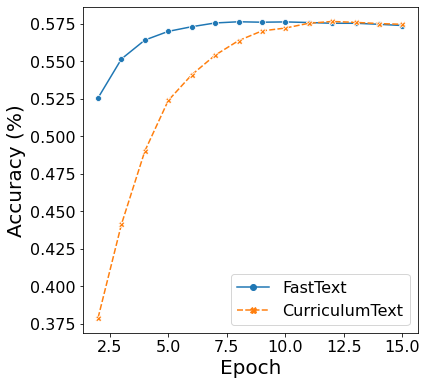

<Figure size 432x288 with 0 Axes>

In [431]:
plot_val_acc_comparison("yelp_review_full")

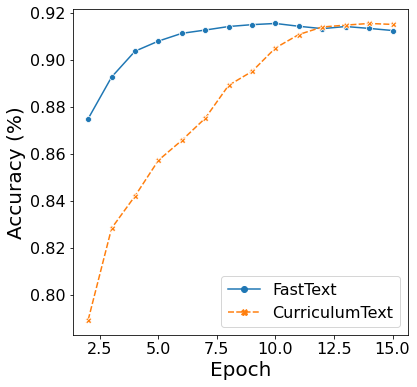

<Figure size 432x288 with 0 Axes>

In [432]:
plot_val_acc_comparison("ag_news")

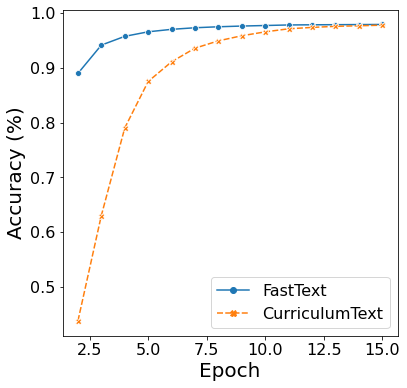

<Figure size 432x288 with 0 Axes>

In [434]:
plot_val_acc_comparison("dbpedia_14")